In [1]:
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
import os
from IPython.display import display
from sklearn.preprocessing import MinMaxScaler

In [2]:
def is_valid_smiles(smiles):
    try:
        mol = Chem.MolFromSmiles(smiles)
        return mol is not None
    except:
        return False

In [3]:
MAX_LEN = 128
BATCH_SIZE = 128
EMB_DIM = 256
LATENT_DIM = 128
N_HEADS = 8
FF_DIM = 512
NUM_LAYERS = 4
VOCAB_SPECIAL = ['<pad>', '<bos>', '<eos>', '<unk>']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используем устройство: {device}")
print(torch.cuda.is_available())
print(torch.version.cuda)
print(torch.cuda.get_device_name(0))

Используем устройство: cuda
True
11.8
NVIDIA GeForce RTX 4050 Laptop GPU


In [4]:
df = pd.read_csv("polymer_bigdata_merged.csv")
df = df.dropna(subset=["polymer_smiles"])

NUM_FEATURES = [
    "Enthalpy of Polymerization (kJ/mol)",
    "Glass Transition Temperature (K)",
    "Specific Heat Capacity (J {gK}^{-1})",
    "Tensile Strength at break (MPa)",
    "Thermal Decomposition Temperature (K)",
    "Youngs Modulus (GPa)"
]

In [5]:
# Нормализация признаков
scaler = MinMaxScaler()
df[NUM_FEATURES] = scaler.fit_transform(df[NUM_FEATURES])

In [6]:
def tokenize(smiles):
    return list(smiles)

all_tokens = set()
for s in df["polymer_smiles"]:
    all_tokens.update(tokenize(s))

tokens = VOCAB_SPECIAL + sorted(list(all_tokens))
token2idx = {t: i for i, t in enumerate(tokens)}
idx2token = {i: t for t, i in token2idx.items()}
vocab_size = len(token2idx)

In [7]:
class ConditionalSMILESDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe["polymer_smiles"].tolist()
        self.features = dataframe[NUM_FEATURES].values.astype(np.float32)

    def __len__(self):
        return len(self.data)

    def encode_smiles(self, smiles):
        tokens_seq = ['<bos>'] + list(smiles) + ['<eos>']
        token_ids = [token2idx.get(t, token2idx['<unk>']) for t in tokens_seq]
        token_ids = token_ids[:MAX_LEN]
        if len(token_ids) < MAX_LEN:
            token_ids += [token2idx['<pad>']] * (MAX_LEN - len(token_ids))
        return torch.tensor(token_ids)

    def __getitem__(self, idx):
        x = self.encode_smiles(self.data[idx])
        tgt_input = x[:-1]
        tgt_output = x[1:]
        feats = torch.tensor(self.features[idx])
        return tgt_input, tgt_output, feats

In [8]:
class ConditionalTransformerVAE(nn.Module):
    def __init__(self, vocab_size, emb_dim, latent_dim, num_heads, ff_dim, num_layers, max_len, feature_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=token2idx['<pad>'])
        self.pos_emb = nn.Parameter(torch.randn(1, max_len, emb_dim))

        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.feat_encoder = nn.Linear(feature_dim, latent_dim)
        self.fc_mu = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.fc_logvar = nn.Linear(emb_dim + latent_dim, latent_dim)
        self.decoder_proj = nn.Linear(latent_dim + latent_dim, emb_dim)

        decoder_layer = nn.TransformerDecoderLayer(d_model=emb_dim, nhead=num_heads, dim_feedforward=ff_dim)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.out = nn.Linear(emb_dim, vocab_size)

    def encode(self, src, feats):
        src_mask = (src == token2idx['<pad>']).bool()
        src_emb = self.emb(src) + self.pos_emb[:, :src.size(1)]
        src_enc = self.encoder(src_emb.transpose(0,1), src_key_padding_mask=src_mask)
        cls_token = src_enc[0, :, :]
        feats_emb = self.feat_encoder(feats)
        combined = torch.cat([cls_token, feats_emb], dim=1)
        mu = self.fc_mu(combined)
        logvar = self.fc_logvar(combined)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        logvar = torch.clamp(logvar, min=-10, max=10)  # фиксируем logvar
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, feats, tgt_inp):
        tgt_mask = (tgt_inp == token2idx['<pad>']).bool()
        z_dec = torch.cat([z, self.feat_encoder(feats)], dim=1).unsqueeze(1).repeat(1, tgt_inp.size(1), 1)
        tgt_emb = self.emb(tgt_inp) + self.pos_emb[:, :tgt_inp.size(1)]
        tgt_seq_mask = nn.Transformer.generate_square_subsequent_mask(tgt_inp.size(1)).to(z.device)
        out = self.decoder(tgt=tgt_emb.transpose(0,1), memory=z_dec.transpose(0,1), tgt_mask=tgt_seq_mask, tgt_key_padding_mask=tgt_mask)
        logits = self.out(out.transpose(0,1))
        return logits

    def forward(self, src, feats, tgt_inp):
        mu, logvar = self.encode(src, feats)
        z = self.reparameterize(mu, logvar)
        logits = self.decode(z, feats, tgt_inp)
        return logits, mu, logvar

In [9]:
def conditional_vae_loss(logits, targets, mu, logvar, pad_idx=token2idx['<pad>']):
    recon_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=pad_idx)
    kl_loss = -0.5 * torch.mean(torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1))
    return recon_loss + kl_loss, recon_loss, kl_loss


In [10]:
def generate_smiles_conditional(model, target_feats, num_samples=5, temperature=1.0):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, LATENT_DIM).to(device)
        target_feats = target_feats.to(device)
        z_dec = torch.cat([z, model.feat_encoder(target_feats)], dim=1).unsqueeze(1)
        input_token = torch.tensor([token2idx['<bos>']] * num_samples).unsqueeze(1).to(device)
        sequences = input_token
        finished = torch.zeros(num_samples, dtype=torch.bool).to(device)

        for _ in range(MAX_LEN - 1):
            emb = model.emb(sequences) + model.pos_emb[:, :sequences.size(1)]
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequences.size(1)).to(device)
            out = model.decoder(emb.transpose(0,1), z_dec.transpose(0,1), tgt_mask=tgt_mask)
            logits = model.out(out.transpose(0,1))[:, -1] / temperature
            probs = torch.softmax(logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1).squeeze(1)
            finished = finished | (next_token == token2idx['<eos>'])
            if finished.all(): break
            sequences = torch.cat([sequences, next_token.unsqueeze(1)], dim=1)

        smiles_list = []
        for seq in sequences:
            tokens_seq = [idx2token[i.item()] for i in seq]
            if '<eos>' in tokens_seq:
                tokens_seq = tokens_seq[:tokens_seq.index('<eos>')]
            smiles = ''.join([t for t in tokens_seq if t not in VOCAB_SPECIAL])
            smiles_list.append(smiles)
        return smiles_list

In [11]:
subset_df = df.head(10_000)
dataset = ConditionalSMILESDataset(subset_df)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

model = ConditionalTransformerVAE(
    vocab_size=len(token2idx),
    emb_dim=EMB_DIM,
    latent_dim=LATENT_DIM,
    num_heads=N_HEADS,
    ff_dim=FF_DIM,
    num_layers=NUM_LAYERS,
    max_len=MAX_LEN,
    feature_dim=len(NUM_FEATURES)
).to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)


C:\Users\goxps\Desktop\polyForge\.venv\Lib\site-packages\torch\nn\modules\transformer.py:382: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [12]:
checkpoint_dir = 'checkpoints_VAE'
os.makedirs(checkpoint_dir, exist_ok=True)
checkpoint_path = os.path.join(checkpoint_dir, 'checkpoint_conditional.pth')

start_epoch = 0
best_loss = float('inf')
loss_history = []

EPOCHS = 20

for epoch in range(start_epoch, start_epoch + EPOCHS):
    model.train()
    total_loss = 0
    total_recon = 0
    total_kl = 0

    for tgt_inp, tgt_out, feats in tqdm(loader, desc=f"Epoch {epoch+1}"):
        tgt_inp, tgt_out, feats = tgt_inp.to(device), tgt_out.to(device), feats.to(device)
        optimizer.zero_grad()
        logits, mu, logvar = model(tgt_inp, feats, tgt_inp)
        loss, recon_loss, kl_loss = conditional_vae_loss(logits, tgt_out, mu, logvar)
        
        if torch.isnan(loss):
            print("NaN detected! Skipping step")
            continue
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # градиентный клиппинг
        optimizer.step()
        
        total_loss += loss.item()
        total_recon += recon_loss.item()
        total_kl += kl_loss.item()

    avg_loss = total_loss / len(loader)
    avg_recon = total_recon / len(loader)
    avg_kl = total_kl / len(loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Recon: {avg_recon:.4f} | KL: {avg_kl:.4f}")

Epoch 1:   0%|                                                                                                                                                                                              | 0/79 [00:00<?, ?it/s]C:\Users\goxps\Desktop\polyForge\.venv\Lib\site-packages\torch\nn\functional.py:5962: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.86it/s]


Epoch 1 | Loss: 3.7559 | Recon: 2.0962 | KL: 1.6597


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  2.98it/s]


Epoch 2 | Loss: 1.6186 | Recon: 1.3357 | KL: 0.2829


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:25<00:00,  3.10it/s]


Epoch 3 | Loss: 1.2993 | Recon: 1.1598 | KL: 0.1396


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.83it/s]


Epoch 4 | Loss: 1.1061 | Recon: 1.0357 | KL: 0.0705


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.84it/s]


Epoch 5 | Loss: 0.9982 | Recon: 0.9516 | KL: 0.0466


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.87it/s]


Epoch 6 | Loss: 0.9281 | Recon: 0.8928 | KL: 0.0353


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  2.99it/s]


Epoch 7 | Loss: 0.8783 | Recon: 0.8506 | KL: 0.0276


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.91it/s]


Epoch 8 | Loss: 0.8393 | Recon: 0.8170 | KL: 0.0224


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.90it/s]


Epoch 9 | Loss: 0.8054 | Recon: 0.7869 | KL: 0.0185


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.90it/s]


Epoch 10 | Loss: 0.7771 | Recon: 0.7614 | KL: 0.0157


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  3.01it/s]


Epoch 11 | Loss: 0.7507 | Recon: 0.7373 | KL: 0.0134


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:26<00:00,  3.01it/s]


Epoch 12 | Loss: 0.7296 | Recon: 0.7180 | KL: 0.0116


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:27<00:00,  2.90it/s]


Epoch 13 | Loss: 0.7078 | Recon: 0.6982 | KL: 0.0097


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.51it/s]


Epoch 14 | Loss: 0.6890 | Recon: 0.6807 | KL: 0.0082


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:21<00:00,  3.62it/s]


Epoch 15 | Loss: 0.6713 | Recon: 0.6644 | KL: 0.0069


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.56it/s]


Epoch 16 | Loss: 0.6570 | Recon: 0.6511 | KL: 0.0059


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.52it/s]


Epoch 17 | Loss: 0.6434 | Recon: 0.6383 | KL: 0.0051


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.52it/s]


Epoch 18 | Loss: 0.6289 | Recon: 0.6244 | KL: 0.0045


Epoch 19: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.50it/s]


Epoch 19 | Loss: 0.6186 | Recon: 0.6147 | KL: 0.0039


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:22<00:00,  3.49it/s]

Epoch 20 | Loss: 0.6071 | Recon: 0.6034 | KL: 0.0037


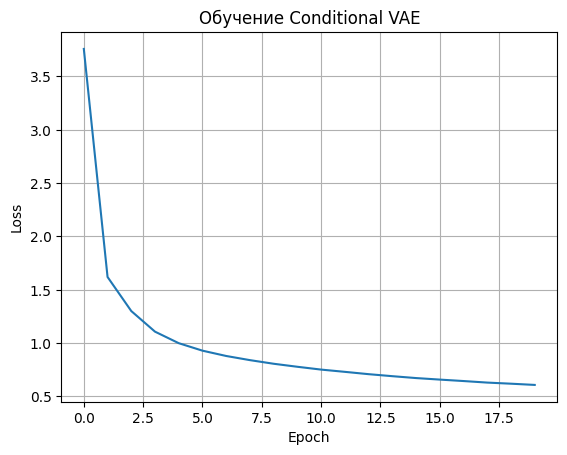

In [13]:
plt.plot(loss_history)
plt.title("Обучение Conditional VAE")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


Generated SMILES:
[1] [*]CCC(CCS[*])(C(=O)NC1CCC1)c1ccccc1 → ✅ VALID
[2] [*]OC1(CC(C)C=C)C(CC([*])=O)c2c[nH](-])c2ccccc21 → ❌ INVALID
[3] [*]SCC1C(NC(N)(C)C2CCCC2)CC1[*] → ✅ VALID
[4] [*]CCC1C(NC(=O)C2CCCCC2)C2[C@@H](C(=O)O[*])C(=O)N(CCC)c2c(=O)cccc21 → ❌ INVALID
[5] [*]CCC1(CCO[*])CN(C(=O)c2ccn(-c3ccccc3)n(C)n2)C1 → ✅ VALID
[6] [*]OCCC1CC2C(NC(=O)c3ccc(F)c(F)(F)F)CCCCC12[*] → ❌ INVALID
[7] [*]C[C@@H](NC(=O)CC1CC(C)(C)CC(F)CS[*])c1ccccc1 → ❌ INVALID
[8] [*]NC1(CCC([*])=O)CCCCCCC1c1ccccc1 → ✅ VALID
[9] [*]SC1CCC([*])CC1CCC11C(=O)C(C)(C)C → ❌ INVALID
[10] [*]OCCC1CC2C(NC(=O)Cc3ccc(F)c(F)c3)CCC12[*] → ✅ VALID
[11] [*]SCCC[C@H]1[C@H]([*])C[C@]1]2CCO → ❌ INVALID
[12] [*]OC(C)[C@H]1CC([*])C(C(=O)NCc2ccccc2OCC)C(=O)OC1 → ✅ VALID
[13] [*]CCC1(CNC(=O)[C@]2(c3ccccc3)c(O)C2)CC(C2)CC1S[*] → ❌ INVALID
[14] [*]Nc1cc(Br)cc1CCC[N([*])C1 → ❌ INVALID
[15] [*]NCC1(CCCC([*])=O)CCC(=O)NC1 → ✅ VALID
[16] [*]=C[C@H]1OC2(C=[*])CN(C#Cc3ccccc3)C(=O)C1C → ❌ INVALID
[17] [*]OCCOC([*])(C)C(=O)NC(c1ccccc1)NC(=O)C1

[13:08:02] SMILES Parse Error: syntax error while parsing: [*]OC1(CC(C)C=C)C(CC([*])=O)c2c[nH](-])c2ccccc21
[13:08:02] SMILES Parse Error: check for mistakes around position 38:
[13:08:02] (CC([*])=O)c2c[nH](-])c2ccccc21
[13:08:02] ~~~~~~~~~~~~~~~~~~~~^
[13:08:02] SMILES Parse Error: Failed parsing SMILES '[*]OC1(CC(C)C=C)C(CC([*])=O)c2c[nH](-])c2ccccc21' for input: '[*]OC1(CC(C)C=C)C(CC([*])=O)c2c[nH](-])c2ccccc21'
[13:08:02] SMILES Parse Error: unclosed ring for input: '[*]CCC1C(NC(=O)C2CCCCC2)C2[C@@H](C(=O)O[*])C(=O)N(CCC)c2c(=O)cccc21'
[13:08:02] SMILES Parse Error: unclosed ring for input: '[*]OCCC1CC2C(NC(=O)c3ccc(F)c(F)(F)F)CCCCC12[*]'
[13:08:02] SMILES Parse Error: unclosed ring for input: '[*]C[C@@H](NC(=O)CC1CC(C)(C)CC(F)CS[*])c1ccccc1'
[13:08:02] SMILES Parse Error: duplicated ring closure 1 bonds atom 11 to itself for input: '[*]SC1CCC([*])CC1CCC11C(=O)C(C)(C)C'
[13:08:02] SMILES Parse Error: syntax error while parsing: [*]SCCC[C@H]1[C@H]([*])C[C@]1]2CCO
[13:08:02] SMILES P

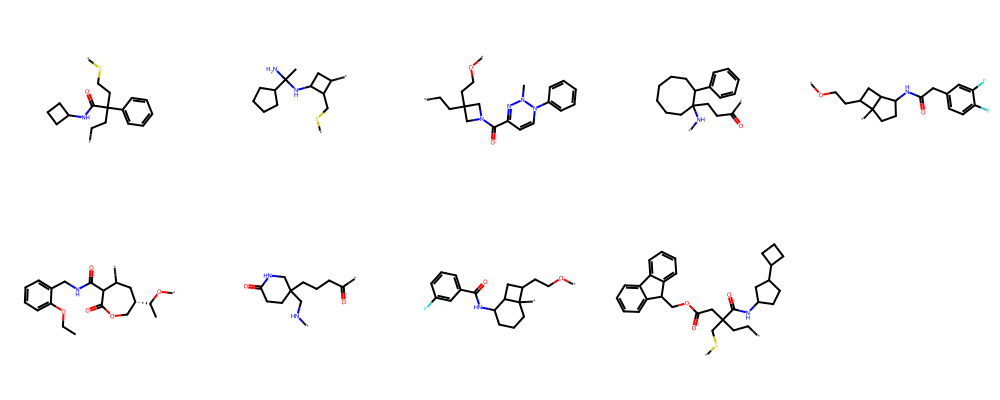

In [14]:
def generate_and_display_conditional(model, dataframe, num_samples=20):
    model.eval()
    # Берем реальные признаки из датасета
    sample_feats = torch.tensor(dataframe[NUM_FEATURES].iloc[:num_samples].values, dtype=torch.float32).to(device)

    # Генерация
    smiles_list = generate_smiles_conditional(model, sample_feats, num_samples=num_samples)

    # Проверка валидности
    valid_smiles = [s for s in smiles_list if is_valid_smiles(s)]
    valid_mols = [Chem.MolFromSmiles(s) for s in valid_smiles]

    # Вывод результатов
    print("\nGenerated SMILES:")
    for i, s in enumerate(smiles_list):
        status = "✅ VALID" if is_valid_smiles(s) else "❌ INVALID"
        print(f"[{i+1}] {s} → {status}")

    print(f"\n✅ Valid: {len(valid_smiles)} / {len(smiles_list)}")

    # Визуализация валидных молекул
    if valid_mols:
        img = Draw.MolsToGridImage(valid_mols, molsPerRow=5, subImgSize=(200,200))
        display(img)
    else:
        print("Нет валидных молекул для визуализации")

# Используем функцию после обучения
generate_and_display_conditional(model, subset_df, num_samples=20)

In [15]:
torch.save(model.state_dict(), "transformer_smiles_conditional.pth")